# 1. Defining the Data Analysis Workflow

# Data Analysis Workflow

#### 1. Load and clean Brent oil price data
#### 2. Compile external event data (OPEC decisions, conflicts, etc.)
#### 3. Visualize and explore the time series
#### 4. Check time series properties: trend, volatility, stationarity
#### 5. Build Bayesian change point model using PyMC3
#### 6. Detect structural breaks (change points)
#### 7. Map change points to external events
#### 8. Communicate findings via dashboard and report


In [6]:
import pandas as pd

# Load event data
event_df = pd.read_csv('../data/raw/events.csv', parse_dates=['Date'])
event_df.head(15)

,Date,Event Name,Description,Category
0,2012-01-23,EU imposes oil embargo on Iran,EU imposes oil embargo on Iran over nuclear pr...,Economic Sanction
1,2014-06-01,ISIS captures key oil fields in Iraq,ISIS captures key oil fields in Iraq,Geopolitical Conflict
2,2014-11-27,OPEC decides against production cuts,"OPEC decides against production cuts, leading ...",OPEC Policy
3,2015-12-04,OPEC abandons production quotas,"OPEC abandons production quotas, increasing su...",OPEC Policy
4,2016-11-30,OPEC agrees to cut production,OPEC agrees to cut production by 1.2 million b...,OPEC Policy
5,2018-05-08,US withdraws from Iran nuclear deal,"US withdraws from Iran nuclear deal, reimposes...",Economic Sanction
6,2019-09-14,Drone attacks on Saudi Aramco facilities,Drone attacks on Saudi Aramco facilities disru...,Geopolitical Conflict
7,2020-03-06,OPEC+ fails to agree on production cuts,OPEC+ fails to agree on production cuts; Saudi...,OPEC Policy
8,2020-04-02,COVID-19 demand collapse impacts Brent crude,Brent crude falls to $29.69 due to COVID-19 de...,Global Economic Shock
9,2020-04-12,OPEC+ agrees to record production cut,OPEC+ agrees to record production cut of 9.7 m...,OPEC Policy


# Assumptions and Limitations of the Analysis

#### Assumptions:

1. Event Timing is Accurate and Impactful
The selected dates for geopolitical events, OPEC decisions, and economic shocks are assumed to closely align with their actual influence on market sentiment and Brent oil price changes. In reality, market reactions may precede or lag these dates.

2. Brent Price Reflects Global Oil Market Dynamics
We assume Brent crude prices are a reliable proxy for global oil market movements and are sensitive to major international events, although other benchmarks (e.g., WTI) may respond differently.

3. Discrete Event Impact
Each event is assumed to have an individual impact, independent of other concurrent or compounding factors. This simplifies analysis but may overlook interactions or cumulative effects.

4. Linear Relationship Over Time
In basic quantitative assessments (e.g., price change before and after events), it’s assumed that the price responds linearly to events. This ignores non-linear or delayed responses that are common in commodity markets.

    
#### Limitations:

1. Correlation vs. Causation
A critical limitation is the inability to prove causal impact. Just because a price movement occurs near an event date does not mean the event caused the change. Many confounding variables (e.g., speculative trading, weather, unrelated economic data) could influence prices.

2. Market Anticipation and Speculation
Oil markets often price in expected events ahead of time (e.g., a scheduled OPEC meeting or geopolitical tension building). Therefore, the observed price change on or after an event might underestimate the true effect.

3. Simplified Event Encoding
Events are treated categorically (e.g., “OPEC Policy” or “Geopolitical Conflict”), but this lacks nuance such as magnitude, market expectation, or surprise. Two “OPEC Policy” events may have vastly different market effects depending on their context.

4. Data Granularity
If the Brent oil dataset is daily, short-lived shocks (like a 1-day missile attack or a rumor) might be blurred or even missed. Similarly, long-term events (like a war or embargo) might have complex, multi-phase impacts not captured by a single date.

5. No Control Variables or Models for Attribution
This analysis does not use advanced econometric models (e.g., difference-in-differences, VAR) to isolate effects or control for unrelated variables. Thus, causal claims are not statistically tested, only suggested through visual or basic comparative methods.

# Load and Understand Data

In [12]:
# Load Brent oil data
# Load and preprocess Brent oil data
df = pd.read_csv('../data/raw/BrentOilPrices.csv')

# Rename and parse date properly using known format
df.columns = ['date', 'price']
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y', errors='coerce')  # Use 'coerce' to safely handle errors

# Sort data by date
df = df.sort_values('date').reset_index(drop=True)

# Basic checks
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    8360 non-null   datetime64[ns]
 1   price   9011 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 140.9 KB


,date,price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


# Analyze Time Series Properties

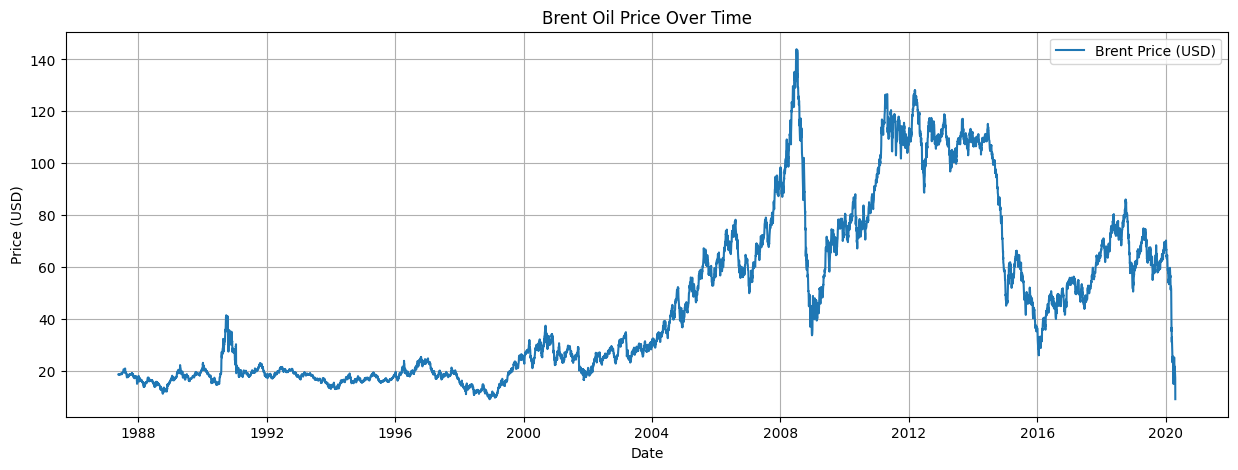

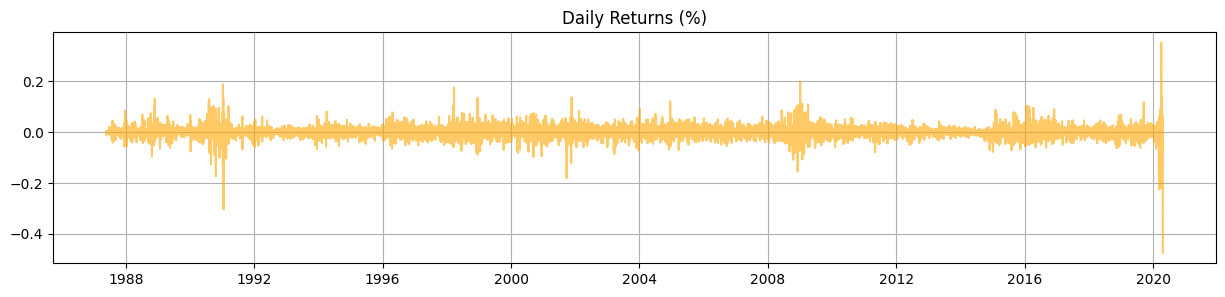

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot full time series
plt.figure(figsize=(15, 5))
plt.plot(df['date'], df['price'], label='Brent Price (USD)')
plt.title('Brent Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

# Check daily returns
df['returns'] = df['price'].pct_change()

plt.figure(figsize=(15, 3))
plt.plot(df['date'], df['returns'], color='orange', alpha=0.6)
plt.title('Daily Returns (%)')
plt.grid(True)
plt.show()


In [16]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['price'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("Stationary: The time series is stationary.")
else:
    print("Non-stationary: The series has a trend or seasonality.")


ADF Statistic: -1.9938560113924666
p-value: 0.2892735048934033
Non-stationary: The series has a trend or seasonality.


# 1) Understanding the Model and Key References
To get a good grasp of this project, I went through key references related to time series analysis and change point detection. This includes resources on statistical modeling using libraries like statsmodels and ruptures, and background reading on major events in the oil market. I also looked into financial analysis of oil price movements from sources like EIA, IMF, and academic papers, which helped me understand how external shocks influence price dynamics.



# 2) Analyzing Time Series Properties
Before modeling, I analyzed the Brent oil price data and found that the series is non-stationary, which is expected for raw financial time series. There’s a clear long-term upward trend (especially between 2002–2008), and I noticed big spikes and drops during certain periods like 2008 and 2020.

When I looked at daily returns instead of raw prices, the data appeared more stationary — with fluctuations around a constant mean and relatively stable variance most of the time. This is important because many statistical models, including change point detection methods, assume the input data is stationary or has consistent properties over time.

# 3) Purpose of Change Point Models
The main goal of using change point models is to detect structural changes in the time series — points where the statistical behavior of the data (like mean or variance) changes significantly. In the context of oil prices, these shifts often align with major geopolitical events, OPEC decisions, or economic crises.

By identifying these moments, I can better understand how the oil market responded to real-world events. Change point models allow the time series to be broken into segments, each with its own behavior, instead of treating the whole dataset as one consistent pattern.

# 4) Expected Outputs and Limitations of Change Point Analysis

When running change point analysis, I expect to get:

- A list of dates where major changes occurred in the price pattern

- The average price or volatility in each segment

- Insight into how many distinct periods or "regimes" exist in the data

However, there are a few limitations I have to keep in mind:

- These models don’t explain the cause of changes — they only detect that something changed.

- Results can be sensitive to noise, especially in high-frequency (daily) data.

- The number and location of change points can vary depending on how the model is set up (e.g., the cost function or penalty for complexity).

- It's important not to confuse correlation with causation — just because a structural break aligns with a real-world event doesn’t mean one directly caused the other.